### Learnings

In [ ]:
## ValueError: too many values to unpack (expected 2)
## features, hog_image = get_hog_features(gray, orient,pix_per_cell, cell_per_block,vis=True, feature_vec=True)
## StandardScaler() expects np.float64
## V = np.concatenate((features_hog, features_spatial)) .. 
## .. Note the double braces to avoid the error: only length-1 arrays can be converted to Python scalars
## hog_channel = 0 # Can be 0, 1, 2, or "ALL"
## to play with HOG parameters to improve accuracy
## Accessing list: windows[1][0] .. or using for loop: for window in windows

### Data Exploration (code)

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from skimage import color, exposure

In [7]:
cars = glob.glob('./DATASETS/vehicles_smallset/*/*.jpeg')
notcars = glob.glob('./DATASETS/non-vehicles_smallset/*/*.jpeg')

In [8]:
# Define a fucntion to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key in data_dict "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


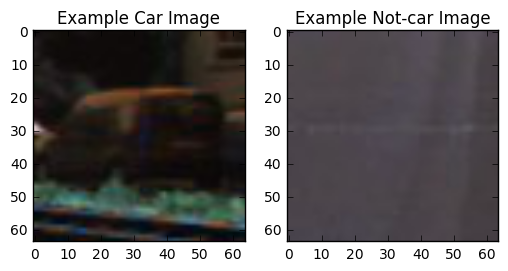

In [9]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [ ]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

In [ ]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

### Normalize Features


In [ ]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features_list = []
for car in cars:
    gray = cv2.cvtColor(cv2.imread(car), cv2.COLOR_BGR2GRAY)
    features = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)
    features_list.append(features)
    features_array = np.asarray(features_list)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X_scaler = StandardScaler().fit(features_array)
# Apply the scaler to X
scaled_X = X_scaler.transform(features_array)


In [ ]:
# plt.figure()
# plt.boxplot(features_array[1:5], 1, '')

In [ ]:
# plt.figure()
# plt.boxplot(SS, 1, '')

In [54]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [ ]:
car_image
car_image_small = cv2.resize(car_image,(32,32))
print(car_image.shape)
print(car_image_small.ravel())
plt.plot(car_image_small.ravel())

In [55]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [ ]:
plt.plot(color_hist(car_image_small))

In [ ]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [ ]:
car_features = extract_features(cars, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

In [ ]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [ ]:
features_list = []
for car in cars:
    gray = cv2.cvtColor(cv2.imread(car), cv2.COLOR_BGR2GRAY)
    features = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)
    features_list.append(features)
    features_array = np.asarray(features_list)

In [ ]:
# Define HOG parameters
# sy, sx = image.shape
# cx, cy = pixels_per_cell
# bx, by = cells_per_block
# n_blocksx = (n_cellsx - bx) + 1
#     n_blocksy = (n_cellsy - by) + 1
#     normalized_blocks = np.zeros((n_blocksy, n_blocksx,
#                                   by, bx, orientations))
orient = 9
pix_per_cell = 8
cell_per_block = 2
feature_list = []

In [ ]:
cars[1]
gray = cv2.cvtColor(cv2.imread(cars[1]), cv2.COLOR_BGR2GRAY)
features = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False)

In [ ]:
numpy.set_printoptions(threshold=numpy.nan)

### Sliding Window

In [67]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=1):
    imcopy = np.copy(img)
    # iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # return the image cpy with boxes drawn
    return imcopy

In [68]:
def sliding_window(img, x_start_stop=[None,None], y_start_stop=[None,None],
                  xy_window=(64,64), xy_overlap=(0.5,0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [41]:
windows = sliding_window(car_image, y_start_stop=(32,64), xy_window=(8,8),xy_overlap=(0,0))

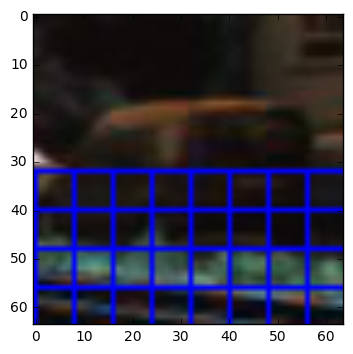

In [42]:
window_img = draw_boxes(car_image, windows, thick=1)
plt.imshow(window_img)

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [49]:
car_test = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

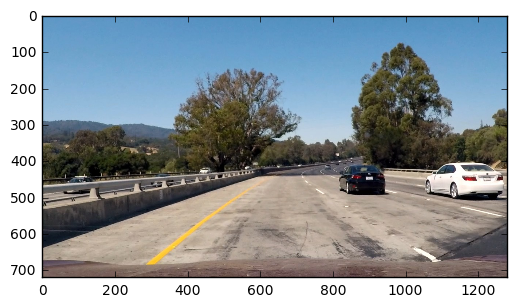

In [50]:
plt.imshow(car_test)

In [52]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

In [58]:
gray = cv2.cvtColor(car_test, cv2.COLOR_RGB2GRAY)
features_hog = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
features_spatial = bin_spatial(car_test)
features_color_hist = color_hist(car_test)
features=(np.concatenate((features_hog, features_spatial, features_color_hist)))
    

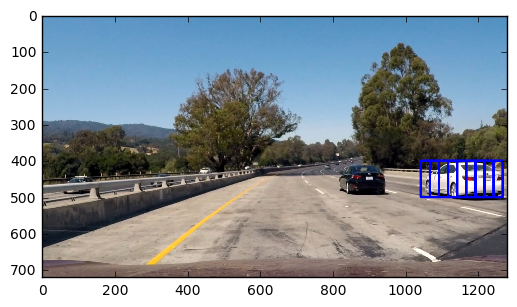

In [104]:
windows = sliding_window(car_test, x_start_stop=(1040,1280), y_start_stop=(400,510), xy_window=(100,100),xy_overlap=(0.75,0.75))
window_img = draw_boxes(car_test, windows, thick=6)
plt.imshow(window_img)

In [126]:
windows[(1:3)]

SyntaxError: invalid syntax (<ipython-input-126-64987a26d9c0>, line 1)

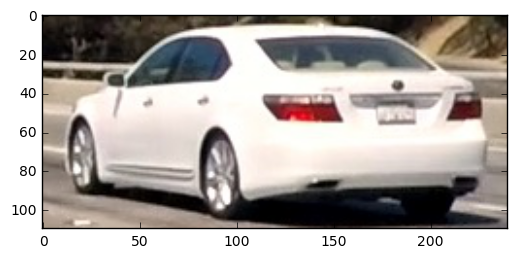

In [81]:
plt.imshow(car_test[400:510,1040:])

In [127]:
windows

[((1040, 400), (1140, 500)),
 ((1065, 400), (1165, 500)),
 ((1090, 400), (1190, 500)),
 ((1115, 400), (1215, 500)),
 ((1140, 400), (1240, 500)),
 ((1165, 400), (1265, 500))]

In [148]:
windows[1][0][1]

400

In [149]:
subimg = car_test[windows[0][0][1]:700,50:200]

In [108]:

subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

IndexError: index 1090 is out of bounds for axis 0 with size 720

In [142]:
subimg = car_test[windows[0]]

IndexError: index 1040 is out of bounds for axis 0 with size 720

In [143]:
car_test.shape

(720, 1280, 3)

In [150]:
# def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256)):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         else: feature_image = np.copy(image)      
#         # Apply bin_spatial() to get spatial color features
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         # Apply color_hist() also with a color space option now
#         hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
#         # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features)))
#     # Return list of feature vectors
#     return features

In [ ]:
# car_features = extract_features(cars, cspace='HSV', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='HSV', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))